# Stock Price Prediction using Machine Learning
## By: Kaustuv Mishra

## Why do we need Stock Price Prediction?
The stock market is known for being volatile and hard to predict. Many researchers have attempted to use time-series data to forecast future stock prices, which could be highly profitable if successful. However, there are numerous variables that influence market fluctuations, and only a few can be accurately quantified, such as historical stock data, trading volume, and current prices. Other fundamental factors, like a company's intrinsic value, assets, performance, and strategies, can also impact investor confidence and stock prices, but they are difficult to incorporate into mathematical models. As a result, using machine learning for stock price prediction is challenging and can be unreliable. Additionally, unforeseen events, such as a pandemic or a war, can quickly impact the stock market, making accurate predictions even more difficult.                                                                   

Rather than trying to accurately predict exact values, analysts typically focus on making short-term predictions that provide a probability estimate of the market's future performance. By using historical data and relevant features, mathematical and machine learning models can forecast short-term fluctuations in the market on an average day. However, predicting the impact of unexpected events, such as market-shattering news, is extremely challenging.

## Stock Price Prediction using Machine Learning
Using machine learning, stock price prediction involves forecasting the future value of stocks traded on stock exchanges to generate profits. Since there are numerous variables involved in predicting stock prices, achieving high accuracy is challenging, and that's where machine learning comes in handy.

## Downloading the Stock Prices Dataset
If we visit finance.yahoo.com/quote/NFLX/history?p=NFLX, we can access the "Historical Data" section, which displays daily stock data. By selecting a specific time period, we can filter the data and download the corresponding CSV file using the download button on the right-hand side.

 Once downloaded, the CSV file will include data for Open, High, Low, Close, Adj Close, and Volume for each date.

## Extracting the Stock Prices Dataset
We can use Pandas to load the downloaded CSV file into a DataFrame. Since each row corresponds to a specific date, we can index the DataFrame by the date column. The data we have collected spans from 22nd Feb 2022 to 22nd Feb 2023, which includes the unpredictable changes and after effects caused by the COVID-19 pandemic. This presents a challenge for our model to accurately predict stock prices during a period of significant market volatility

In [1]:
import pandas as pd
import numpy as np

# Load data
stock_data = pd.read_csv(r'C:\Users\ASUS\Downloads\NFLX.csv', index_col = 'Date')
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-22,388.950012,392.420013,373.019989,377.380005,377.380005,6697500
2022-02-23,382.720001,386.000000,366.660004,367.459991,367.459991,4614300
2022-02-24,355.089996,390.730011,354.720001,390.029999,390.029999,7068700
2022-02-25,386.609985,391.290009,375.579987,390.799988,390.799988,4841600
2022-02-28,387.329987,397.750000,382.130005,394.519989,394.519989,5035000


The sudden drop in the stock price around May 2022 and the subsequent steady growth until recently pose a significant challenge for any machine learning model attempting to predict the stock prices. As a result, we will concentrate on evaluating the model's performance in predicting the more recent stock prices, as we have limited confidence in its ability to accurately estimate the abrupt changes that occurred in Feb 2022 and February 2023. Therefore, we will train the model on past data and assess its ability to predict future prices with a focus on the most recent values.

Plotting the High and Low points of the market, we see the below graph.

The following code uses matplotlib to create a plot of the DataFrame columns against the Date index column. To ensure that the dates are displayed clearly and legibly on the plot, lines 6-8 convert the date strings to datetime format. The interval parameter in line 7 specifies the number of days between each tick on the date axis, which can be adjusted to increase or decrease the density of the tick marks on the plot.

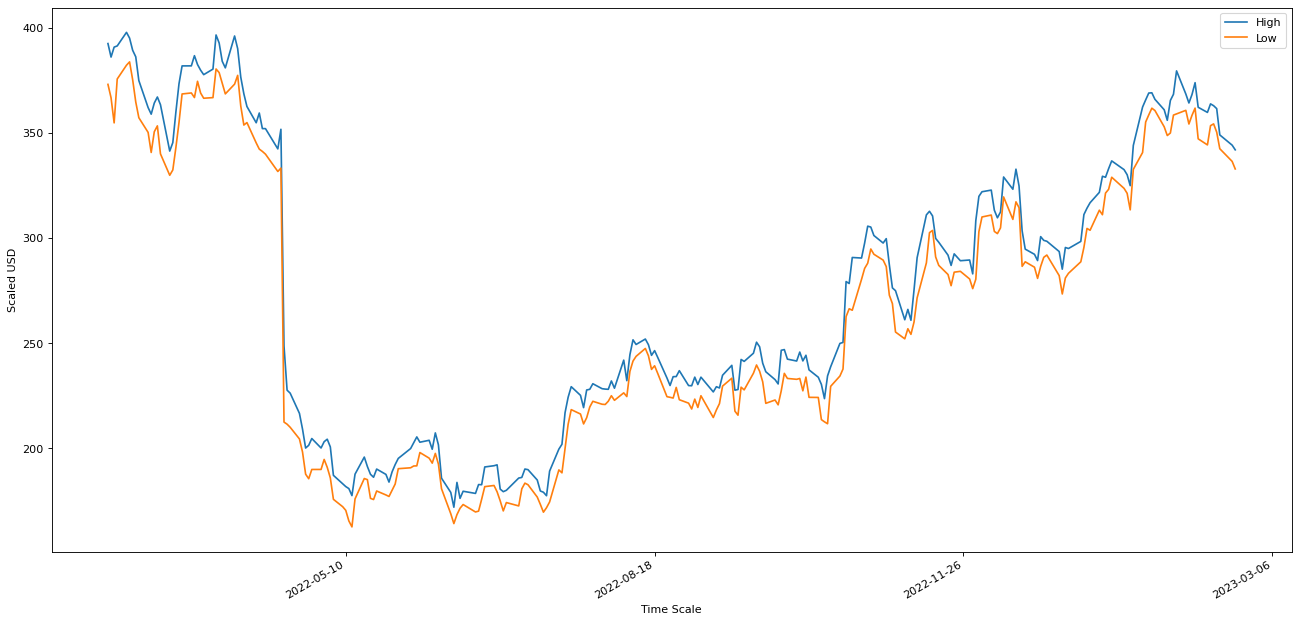

In [2]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

# Define the figure size and resolution
fig, ax = plt.subplots(figsize=(20, 10), dpi=80)

# Format the x-axis with date labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=100))

# Convert the index to datetime.date objects
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data.index]

# Plot the high and low data
ax.plot(x_dates, stock_data['High'], label='High')
ax.plot(x_dates, stock_data['Low'], label='Low')

# Add labels and legend
ax.set_xlabel('Time Scale')
ax.set_ylabel('Scaled USD')
ax.legend()

# Auto-format the x-axis date labels
fig.autofmt_xdate()

# Show the plot
plt.show()

## Importing the Libraries
While we'll be using different libraries and modules to preprocess data with scikit-learn and build LSTM models with Tensorflow Keras, it's helpful to gather all of our import statements together in a single group. You can add new import statements to this group as needed to import additional modules.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

## Data Preprocessing
When working with real-world data in machine learning models, it's important to normalize or rescale the data to a fixed range. By doing so, we can prevent features with larger numeric values from dominating the model and introducing biases, which can help the model converge more quickly.





To begin, we define the features and target variables as previously discussed.

In [4]:
# Set the target variable to be the 'Close' column
target_y = stock_data['Close']
# Set the feature variables to be the first three columns of the DataFrame
X_feat = stock_data.iloc[:,0:3]

Our next step is to use a StandardScaler to rescale the values of our data, ensuring they fall within the range of -1 to 1.

In [5]:
#Feature Scaling
sc = StandardScaler() # Create a StandardScaler object

# Scale the feature variables using the StandardScaler object
X_ft = sc.fit_transform(X_feat.values)

# Create a new DataFrame with the scaled values and the original column names and indices
X_ft = pd.DataFrame(columns= X_feat.columns, data=X_ft, index=X_feat.index)

While scikit-learn offers the widely used MinMaxScaler module for preprocessing, it may not be suitable for our stock price data since the maximum and minimum values may occur on different days, leading to undesirable influences on other data. Therefore, we opt to use the StandardScaler module instead, which should not result in a significant difference in values.

To prepare our data for training an LSTM model, we need to split it into training and testing sets using a custom function called lstm_split(). This function creates windows of size "n_steps" starting from the first data sample and ending at the "n_steps"th sample from the end, which is necessary for training an LSTM model. The function ensures that the target value corresponds to the "n_steps"th index, which allows us to predict the target value based on the features of the previous data samples. For example, if "n_steps" is 10, the first element in the feature matrix X will include features from 10 data samples, and the target variable y will contain the target value of the 10th data sample.

In [6]:
def lstm_split(data, n_steps):
    # Initialize empty lists for input and output sequences
    input_seqs, output_seqs = [], []
    
    # Create sequences of length n_steps from the input data
    for i in range(len(data) - n_steps + 1):
        input_seq = data[i:i + n_steps, :-1]
        output_seq = data[i + n_steps - 1, -1]
        input_seqs.append(input_seq)
        output_seqs.append(output_seq)
    
    # Convert input and output sequences to numpy arrays
    X = np.array(input_seqs)
    y = np.array(output_seqs)
    
    return X, y

# Train and Test Sets for Stock Price Prediction
After defining our custom function for splitting the data, we proceed to split it into training and testing sets. Since shuffling is not allowed in time-series datasets, we perform a simple split. To predict the current value, we take two steps worth of past data, meaning that the model considers yesterday's and today's values to predict today's closing price.

In [7]:
# Split the data into input and output sequences
X, y = lstm_split(stock_data.values, n_steps=2)

# Define the proportion of data to be used for training
train_proportion = 0.8

# Calculate the index to split the data
split_idx = int(np.ceil(len(X) * train_proportion))

# Get the date index for the original DataFrame
date_index = stock_data.index

# Split the data into training and testing sets
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

# Print the shapes of the training and testing sets
print(X.shape, X_train.shape, X_test.shape, y_test.shape)


(251, 2, 5) (201, 2, 5) (50, 2, 5) (50,)


It's important to note that the size of X1, the feature matrix for training our LSTM model, is n_steps smaller than the original dataset. This is because the last two samples in the original dataset cannot be used for training or prediction since their corresponding ground truth values are not available

# Building the LSTM model
To construct a basic LSTM model with a single unit, we will utilize the Sequential and LSTM modules offered by Tensorflow Keras.

In [8]:
# Create a Sequential model
model = Sequential()

# Add an LSTM layer with 50 units, input shape of (n_steps, n_features), and 'relu' activation
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))

# Add another LSTM layer with 50 units and 'relu' activation
model.add(LSTM(50, activation='relu'))

# Add a Dense layer with 1 unit
model.add(Dense(1))

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 50)             11200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31,451
Trainable params: 31,451
Non-trainable params: 0
_________________________________________________________________


Now we can fit this simple model to the training data.

In [9]:
history = model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=2, shuffle=False)

Epoch 1/100
51/51 - 2s - loss: 251776435486720.0000 - 2s/epoch - 36ms/step
Epoch 2/100
51/51 - 0s - loss: 251726154170368.0000 - 86ms/epoch - 2ms/step
Epoch 3/100
51/51 - 0s - loss: 251426060107776.0000 - 83ms/epoch - 2ms/step
Epoch 4/100
51/51 - 0s - loss: 250296919916544.0000 - 69ms/epoch - 1ms/step
Epoch 5/100
51/51 - 0s - loss: 247143356956672.0000 - 69ms/epoch - 1ms/step
Epoch 6/100
51/51 - 0s - loss: 239872816185344.0000 - 83ms/epoch - 2ms/step
Epoch 7/100
51/51 - 0s - loss: 227665780932608.0000 - 79ms/epoch - 2ms/step
Epoch 8/100
51/51 - 0s - loss: 210617747111936.0000 - 94ms/epoch - 2ms/step
Epoch 9/100
51/51 - 0s - loss: 190916832788480.0000 - 82ms/epoch - 2ms/step
Epoch 10/100
51/51 - 0s - loss: 172848375136256.0000 - 80ms/epoch - 2ms/step
Epoch 11/100
51/51 - 0s - loss: 159883227824128.0000 - 88ms/epoch - 2ms/step
Epoch 12/100
51/51 - 0s - loss: 152515312091136.0000 - 78ms/epoch - 2ms/step
Epoch 13/100
51/51 - 0s - loss: 149029325373440.0000 - 85ms/epoch - 2ms/step
Epoch 14/

Since the model and data are relatively uncomplicated, we observed that the loss reduction plateaus after only 20 epochs. This is evident when plotting the training loss against the number of epochs, as we can see that the LSTM model does not significantly improve beyond 10-20 epochs.

# Performance Evaluation on Test Set
Regardless of the limited improvement beyond a certain number of epochs, we can still evaluate the performance of our LSTM model on a test set by following the steps below.

In [10]:
# Make predictions
y_pred = model.predict(X_test)


2/2 [==============================] - 0s 0s/step


To access the performance of the model, we initially plot the curve for the actual values and compare it to the curve for the predicted values.

From the comparison between the actual and predicted values, we can observe that the LSTM model is capable of reproducing the trends in the stock prices up to a certain degree. Furthermore, it appears to have accurately captured the recent decrease in prices.

As previously determined, we can also compute the RMSE and MAPE values as performance metrics to compare our model's performance with other approaches in the future.

Next, we will attempt to fit the same model with a larger number of time steps, specifically n_steps=10. We will modify the appropriate block of code and run the entire process again using the same model as before.

In [11]:
# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print("RSME: ", rmse)
print("MAPE: ", mape)

RSME:  6243265.296368732
MAPE:  0.818980410603727


In [12]:
# Create a Sequential model
model = Sequential()

# Add an LSTM layer with 100 units, input shape of (n_steps, n_features), and 'relu' activation
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))

# Add another LSTM layer with 100 units and 'relu' activation
model.add(LSTM(100, activation='relu'))

# Add a Dense layer with 50 units and default 'linear' activation
model.add(Dense(50))

# Add a Dense layer with 1 unit and default 'linear' activation
model.add(Dense(1))

# Compile the model with mean squared error loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 100)            42400     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 127,901
Trainable params: 127,901
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Calculate the root mean squared error (RMSE) and mean absolute percentage error (MAPE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print the RMSE and MAPE
print("RMSE:", rmse)
print("MAPE:", mape) 

RMSE: 6243265.296368732
MAPE: 0.818980410603727


After evaluating the LSTM model's performance, we can now compare it to traditional statistical techniques such as SMA and EMA.

In [14]:
# Split the data into input and output sequences
n_steps = 10
X1, y1 = lstm_split(stock_data.values, n_steps=n_steps)

# Define the train/test split ratio
train_split = 0.8

# Determine the split index
split_idx = int(np.ceil(len(X1) * train_split))

# Get the date index
date_index = stock_data.index

# Split the data into training and testing sets
X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]
X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:-n_steps]

# Print the shapes of the data arrays
print(X1.shape, X_train.shape, X_test.shape, X_test_date.shape, y_test.shape)


(243, 10, 5) (195, 10, 5) (48, 10, 5) (47,) (48,)


# LSTM vs. Simple Moving Average vs. Exponential Moving Average for Stock Price Prediction

# Simple Moving Average
Based on this, we find the results as below:

Test RMSE: 39.336
Test MAPE: 0.096


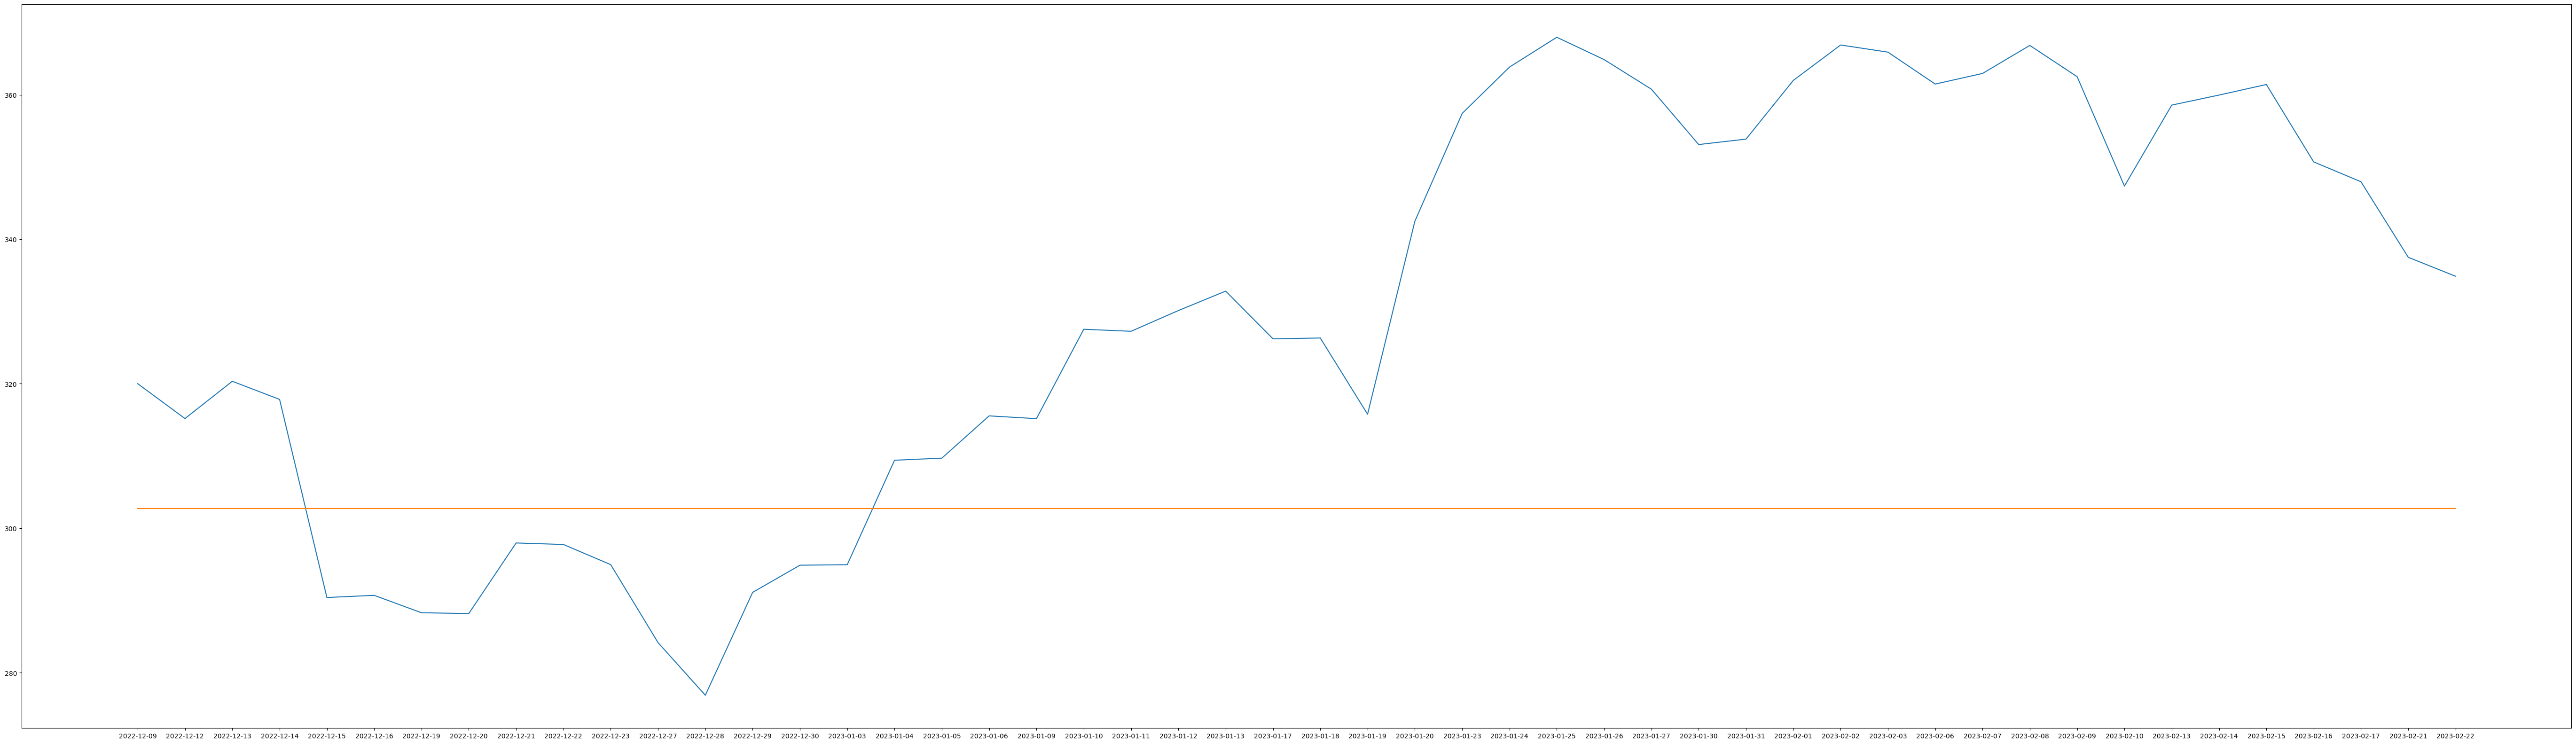

In [15]:
train_split = 0.8
split_idx = int(np.ceil(len(stock_data)*train_split))

train_data = stock_data[['Close']].iloc[:split_idx]
test_data = stock_data[['Close']].iloc[split_idx:]

test_pred = np.array([train_data.rolling(10).mean().iloc[-1]]*len(test_data)).reshape((-1,1))

rmse = mean_squared_error(test_data, test_pred, squared=False)
mape = mean_absolute_percentage_error(test_data, test_pred)

print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

# Plot the results
plt.figure(figsize= (70,20))
plt.plot(test_data)
plt.plot(test_pred)
plt.show()

# Exponential Moving Average
Instead of creating our own implementation of EMA, we can use the SimpleExpSmoothing module provided by statsmodels in Python. By adjusting the smoothing_level parameter, we can fine-tune the model to achieve optimal performance. We observed that a lower value for smoothing_level resulted in better results.

In [16]:
import statsmodels.api as sm

X = stock_data[['Close']].values
train_split = 0.8
split_idx = int(np.ceil(len(X)*train_split))
train = X[:split_idx]
test = X[split_idx:]
test_pred = np.array([]).reshape((0,1))

for i in range(len(test)):
    train_fit = np.concatenate((train, np.asarray(test_pred)))
    fit = sm.tsa.SimpleExpSmoothing(np.asarray(train_fit)).fit(smoothing_level=0.2)
    test_forecast = fit.forecast(1)
    test_pred = np.concatenate((np.asarray(test_pred), test_forecast.reshape((-1,1))))

rmse = mean_squared_error(test, test_pred, squared=False)
mape = mean_absolute_percentage_error(test, test_pred)

print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 37.475
Test MAPE: 0.092


Comparing the performance of SMA and EMA with LSTM in predicting stock price data, we find that the latter significantly outperforms the former. Hyperparameter tuning, including adjusting the number of cells, batch size, and loss function, could further improve the LSTM model's performance.